# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [1]:
import os.path
from urllib.request import urlretrieve
import requests
import zipfile
import io
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme()

%pip install tqdm
from tqdm import tqdm

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    explained_variance_score,
    max_error
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,
    ParameterSampler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

import xgboost as xgb
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_dataset.csv',
                 sep=',',
                 quotechar='"',
                 dtype=None,
                 parse_dates=True,
                 low_memory=False)
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("string")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2019) & (df['year'] <= 2022)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,o3_lag_1Y,pm_lag_2Y,co_lag_2Y,o3_lag_2Y,pm_lag_1M,co_lag_1M,o3_lag_1M,pm_lag_1W,co_lag_1W,o3_lag_1W
0,2019,1,1,Jharkhand,8.720000,0.000000,16.436667,1,1,1,...,1.770000,NaN,NaN,NaN,8.720000,0.000000,15.982917,8.720000,0.000000,36.930000
1,2019,1,1,Kerala,65.784118,2.947647,68.821176,1,1,1,...,46.665833,NaN,NaN,NaN,42.000000,1.610833,46.917083,33.250000,2.490000,47.376250
2,2019,1,1,Andhra Pradesh,79.580521,1.041757,59.043854,1,1,1,...,51.598333,44.684783,0.531739,16.971739,53.458646,0.962083,47.303333,82.668646,0.890687,67.567396
3,2019,1,1,Tamil Nadu,121.566597,0.848472,56.341250,1,1,1,...,28.469167,40.159167,1.061667,21.971250,22.963333,0.813472,22.469792,82.262500,1.040417,36.147292
4,2019,1,1,Gujarat,112.998750,0.494167,56.815833,1,1,1,...,44.890000,115.899583,1.082083,43.001250,89.591250,0.705833,38.321250,80.867917,0.524167,70.607500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34966 entries, 0 to 34965
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        34966 non-null  int64  
 1   month       34966 non-null  int64  
 2   dayofmonth  34966 non-null  int64  
 3   state       34966 non-null  string 
 4   PM2.5       34966 non-null  float64
 5   CO          34966 non-null  float64
 6   O3          34966 non-null  float64
 7   dayofweek   34966 non-null  int64  
 8   quarter     34966 non-null  int64  
 9   weekofyear  34966 non-null  int64  
 10  dayofyear   34966 non-null  int64  
 11  pm_lag_1Y   30238 non-null  float64
 12  co_lag_1Y   30238 non-null  float64
 13  o3_lag_1Y   30238 non-null  float64
 14  pm_lag_2Y   26494 non-null  float64
 15  co_lag_2Y   26494 non-null  float64
 16  o3_lag_2Y   26494 non-null  float64
 17  pm_lag_1M   34546 non-null  float64
 18  co_lag_1M   34546 non-null  float64
 19  o3_lag_1M   34546 non-nul

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_2Y`: PM2.5 ritardato di 2 anni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_2Y`: CO ritardato di 2 anni
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_2Y`: O3 ritardato di 2 anni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [4]:
target = 'PM2.5'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
predictors = date_features + lag_features

In [5]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [6]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati di create_train_test_sets eliminando l’indice precedente,
# in modo da partire da zero e avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21195 entries, 0 to 21194
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  21195 non-null  int64  
 1   dayofweek   21195 non-null  int64  
 2   dayofyear   21195 non-null  int64  
 3   weekofyear  21195 non-null  int64  
 4   month       21195 non-null  int64  
 5   quarter     21195 non-null  int64  
 6   year        21195 non-null  int64  
 7   pm_lag_1Y   21195 non-null  float64
 8   pm_lag_2Y   21195 non-null  float64
 9   pm_lag_1M   21195 non-null  float64
 10  pm_lag_1W   21195 non-null  float64
 11  co_lag_1Y   21195 non-null  float64
 12  co_lag_2Y   21195 non-null  float64
 13  co_lag_1M   21195 non-null  float64
 14  co_lag_1W   21195 non-null  float64
 15  o3_lag_1Y   21195 non-null  float64
 16  o3_lag_2Y   21195 non-null  float64
 17  o3_lag_1M   21195 non-null  float64
 18  o3_lag_1W   21195 non-null  float64
dtypes: float64(12), int64(7)


In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5299 entries, 0 to 5298
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dayofmonth  5299 non-null   int64  
 1   dayofweek   5299 non-null   int64  
 2   dayofyear   5299 non-null   int64  
 3   weekofyear  5299 non-null   int64  
 4   month       5299 non-null   int64  
 5   quarter     5299 non-null   int64  
 6   year        5299 non-null   int64  
 7   pm_lag_1Y   5299 non-null   float64
 8   pm_lag_2Y   5299 non-null   float64
 9   pm_lag_1M   5299 non-null   float64
 10  pm_lag_1W   5299 non-null   float64
 11  co_lag_1Y   5299 non-null   float64
 12  co_lag_2Y   5299 non-null   float64
 13  co_lag_1M   5299 non-null   float64
 14  co_lag_1W   5299 non-null   float64
 15  o3_lag_1Y   5299 non-null   float64
 16  o3_lag_2Y   5299 non-null   float64
 17  o3_lag_1M   5299 non-null   float64
 18  o3_lag_1W   5299 non-null   float64
dtypes: float64(12), int64(7)
me

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [9]:
categorical_features = X.select_dtypes(include=["string"]).columns.tolist()
numerical_features   = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [10]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l'allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo la funzione `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:

1. **$R^2$ (Coefficiente di Determinazione)**  
   Misura quanto bene un modello riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta).  
   Un $R^2_{\text{test}}$ significativamente inferiore rispetto a $R^2_{\text{train}}$ indica possibile overfitting.  
   *(Più alto è, meglio è.)*

2. **Root Mean Squared Error (RMSE)**  
   Misura la deviazione standard degli errori di previsione (la radice quadrata del MSE). Penalizza maggiormente gli errori più grandi.  
   *(Più basso è, meglio è.)*

3. **Mean Absolute Error (MAE)**  
   Rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. È meno sensibile agli outlier rispetto all’RMSE.  
   *(Più basso è, meglio è.)*

4. **Mean Absolute Percentage Error (MAPE)**  
   Misura la precisione percentuale di un sistema di previsione. Indica, in media, quanto si discosta una previsione rispetto al valore reale.  
   *(Più basso è, meglio è.)*

5. **Mean Squared Logarithmic Error (MSLE)**  
   Utile quando si vuole penalizzare maggiormente gli errori relativi per valori piccoli e avere tolleranza su valori grandi.  
   *(Più basso è, meglio è.)*

6. **Explained Variance Score**  
   Misura la proporzione della varianza spiegata dal modello, simile a $R^2$, ma può essere più informativo in caso di regressione non lineare.  
   *(Più alto è, meglio è.)*

7. **Max Error**  
   Misura l’errore assoluto massimo commesso in una previsione.  
   *(Più basso è, meglio è.)*


In [11]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, np.maximum(y_pred, 0))
    evs = explained_variance_score(y_test, y_pred)
    me = max_error(y_test, y_pred)

    rmse_low, rmse_high = bootstrap_ci(lambda a,b: np.sqrt(mean_squared_error(a, b)), y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    out_cpu = out.detach().cpu().numpy()
    # Se il modello restituisce shape (N,1), appiattiamo a (N,)
    if out_cpu.ndim == 2 and out_cpu.shape[1] == 1:
        return out_cpu.ravel()
    return out_cpu

def get_torch_estimator_scores(model_name, model,
                               X_train, y_train,
                               X_test, y_test,
                               device):
    y_pred_train = predict_torch(model, X_train, device)
    y_pred_test  = predict_torch(model, X_test,  device)

    y_train_np = y_train.detach().cpu().numpy().ravel()
    y_test_np  = y_test.detach().cpu().numpy().ravel()

    r2_tr = r2_score(y_train_np, y_pred_train)
    r2_te = r2_score(y_test_np,  y_pred_test)

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_test))
    rmse_low, rmse_high = bootstrap_ci(
        lambda a, b: np.sqrt(mean_squared_error(a, b)),
        y_test_np, y_pred_test
    )

    mae = mean_absolute_error(y_test_np, y_pred_test)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test_np, y_pred_test)
    mape = mean_absolute_percentage_error(y_test_np, y_pred_test)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error,
                                       y_test_np, y_pred_test)
    msle = mean_squared_log_error(y_test_np, np.maximum(y_pred_test, 0))
    evs = explained_variance_score(y_test_np, y_pred_test)
    me = max_error(y_test_np, y_pred_test)

    all_scores.append([
        model_name, r2_tr, r2_te,
        rmse, rmse_low, rmse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high,
        msle, evs, me
    ])

## Regressione lineare
Il modello più semplice da addestrare è la regressione lineare, senza filtri polinomiali o regolarizzazioni. Grazie all'elevato numero di dati usato per l'addestramento, si possono ottenere degli ottimi risultati, anche se migliorabili, già con questo primo modello.

In [12]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [13]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: user 32.6 ms, sys: 60 µs, total: 32.6 ms
Wall time: 33.6 ms


## Regressione polinomiale
Per provare ad ottenere risultati migliori, vengono introdotte le feature polinomiali, che aggiungono nuove feature di grado superiore. Si esclude il bias, che consiste nel valore dell'intercetta, e si escludono i prodotti tra le diverse feature, per esempio i doppi prodotti in una regressione polinomiale di grado 2.

In [14]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [15]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: user 542 ms, sys: 25.8 ms, total: 567 ms
Wall time: 360 ms


## Regressione LASSO
La regressione LASSO è un'ottima tecnica per selezionare le feature più importanti, poichè la discesa del gradiente si ferma su un vertice di un ipercubo centrato sull'origine, quindi azzera i parametri delle variabili meno rilevanti.

In [16]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [17]:
%time model.fit(X_train, y_train)

CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 17.1 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('regr', Lasso(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Lasso
Per ricercare gli iperparametri migliori nei prossimi modelli da addestrare, verrà usata la grid search o random search, che addestra il modello con tutte le combinazioni possibili di iperparametri selezionati. <br>
All'interno della grid search, suddividiamo i dati in 5 sottoinsiemi disgiunti, i fold della cross validation, per garantire che il modello riesca a generalizzare su dati non visti. <br>
Con la grid search si ottiene lo score del modello al variare dell'iperparametro della regolarizzazione LASSO per vedere quanta regolarizzazione è necessaria ai fini dell'addestramento.

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

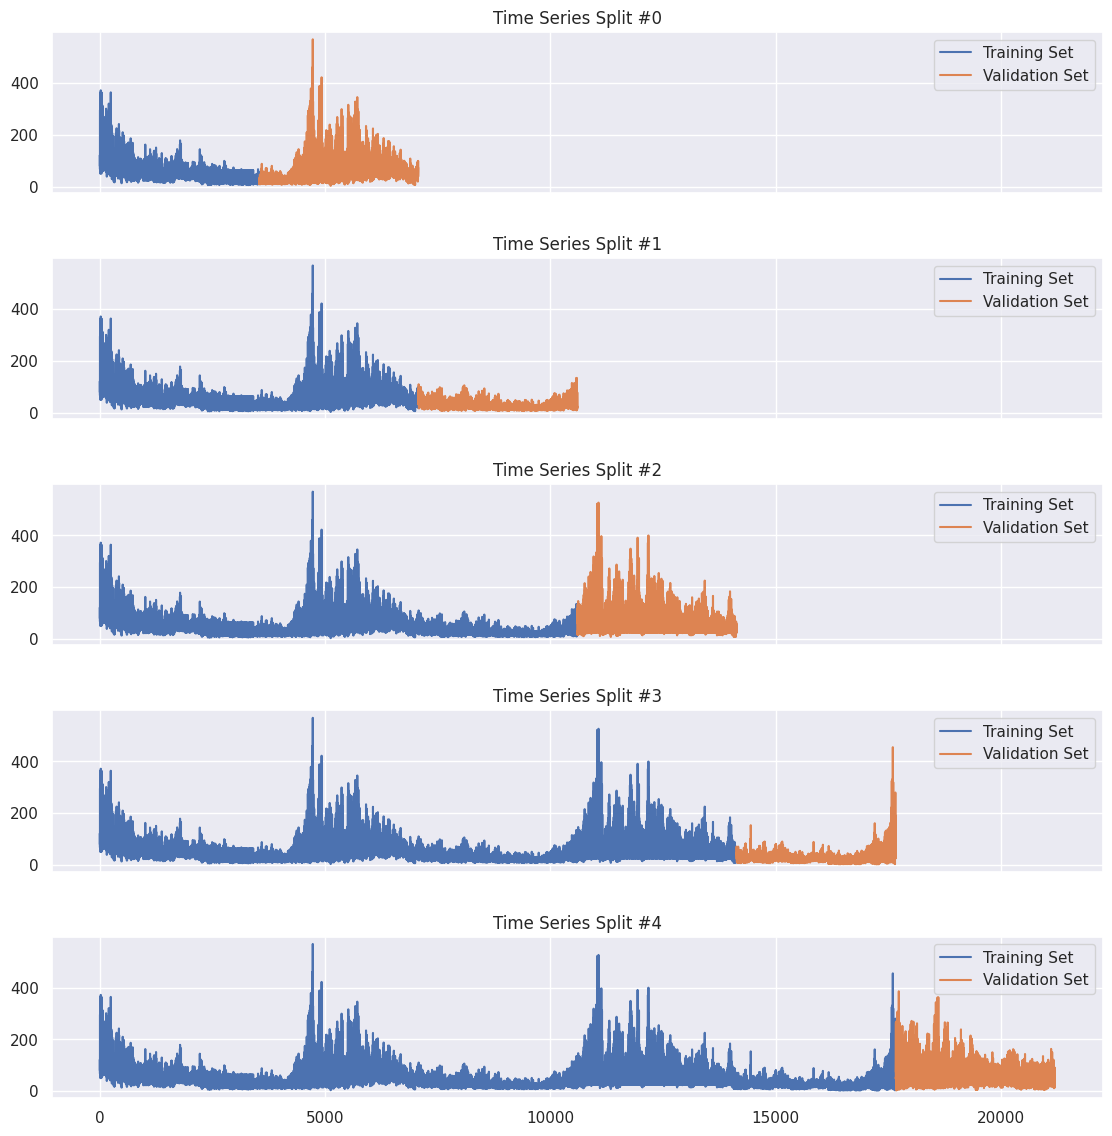

In [19]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

In [20]:
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=5, cv=tscv, n_jobs=N_JOBS)

In [21]:
%time gs.fit(X_train, y_train);
print()

CPU times: user 177 ms, sys: 18.4 ms, total: 196 ms
Wall time: 10.5 s



In [22]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

In [23]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

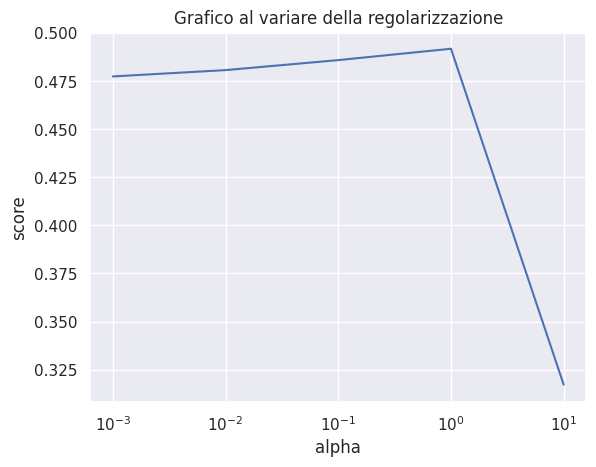

In [24]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Ridge
Proviamo la regolarizzazione con feature polinomiali per ridurre un eventuale overfitting.

In [25]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [26]:
%time model.fit(X_train, y_train)

CPU times: user 172 ms, sys: 13.4 ms, total: 186 ms
Wall time: 158 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', Ridge(alpha=1, max_iter=10000))])

### Grid Search per l'iperparametro della Ridge

In [27]:
alphas = np.logspace(-2, 8, num=12)
grid = {"regr__alpha": alphas}
gs = RandomizedSearchCV(model, grid, n_iter=12, cv=tscv, n_jobs=N_JOBS)

In [28]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 395 ms, sys: 34.3 ms, total: 429 ms
Wall time: 4.1 s



In [29]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

In [30]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

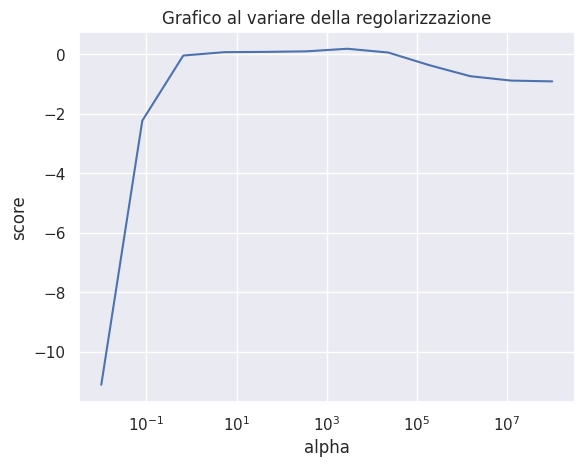

In [31]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Elastic Net
Questa regressione unisce la regolarizzazione LASSO e la regolarizzazione Ridge.

In [32]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [33]:
%time model.fit(X_train, y_train)

CPU times: user 2.92 s, sys: 18.2 ms, total: 2.94 s
Wall time: 1.88 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_2Y',
                                                   'pm_lag_1M', 'pm_lag_1W',
                                                   'co_lag_1Y', 'co_lag_2Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_2Y',
                                                   'o3_lag_1M', 'o3_lag_1W']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', ElasticNet(alpha=0.2, l1_ratio=0.1))])

### Grid Search per Elastic Net
Nella grid search cerchiamo i valori migliori di `alpha`, iperparametro della regolarizzazione, e di `l1_ratio`, iperparametro per gestire l'unione di LASSO e Ridge.

In [34]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [35]:
%time gs.fit(X_train, y_train);
print()

CPU times: user 1.75 s, sys: 59.2 ms, total: 1.81 s
Wall time: 32.9 s



In [36]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)

## Regressione con funzioni kernel
Per ovviare ai problemi di prestazioni dei modelli con feature polinomiali, usiamo il kernel trick per evitare di creare un numero elevato di feature aggiuntive.

## Funzioni kernel polinomiali

In [37]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [38]:
%time model.fit(X_train, y_train)
print()

CPU times: user 2min 59s, sys: 5.6 s, total: 3min 5s
Wall time: 2min 1s



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.19081e-24): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


### Grid Search per funzioni kernel polinomiali
Questa grid search cerca i valori ottimali del peso della regolarizzazione e del grado della funzione kernel polinomiale.

In [39]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = |\text{max_depth}| \times |\text{min_samples_split}| = 28 \times 4 = 84 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 84.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/84} = 2.3026 \times \frac{84}{10} \approx 20
$$

Quindi, con **20 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 84 tentativi.




**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [40]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 3min 17s, sys: 5.77 s, total: 3min 23s
Wall time: 45min 9s



In [41]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

In [42]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha","param_regr__degree","mean_test_score"]]
results_0_1 = results[results["param_regr__alpha"] == 0.1]
results_1 = results[results["param_regr__alpha"] == 1]
results_10 = results[results["param_regr__alpha"] == 10]

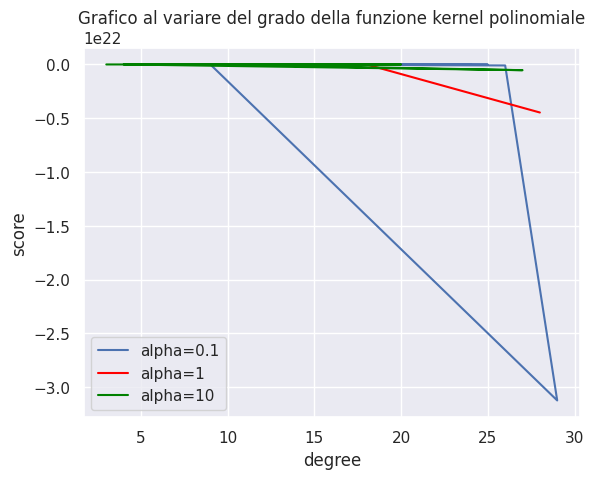

In [43]:
plt.plot(results_0_1["param_regr__degree"], results_0_1["mean_test_score"])
plt.plot(results_1["param_regr__degree"], results_1["mean_test_score"], c="red")
plt.plot(results_10["param_regr__degree"], results_10["mean_test_score"], c="green")
plt.xlabel('degree')
plt.ylabel('score')
plt.legend(["alpha=0.1","alpha=1","alpha=10"])
plt.title('Grafico al variare del grado della funzione kernel polinomiale')
plt.show()

## Funzioni kernel gaussiane

Testiamo anche funzioni kernel diverse, ad esempio RBF (_radial basis function_). <br>
La funzione RBF ha la forma di una gaussiana.

In [44]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [45]:
%time model.fit(X_train, y_train)
print()

CPU times: user 2min 59s, sys: 3.22 s, total: 3min 2s
Wall time: 1min 51s



### Grid Search per funzioni kernel gaussiane

In [46]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = RandomizedSearchCV(model, grid, n_iter=9, cv=tscv, n_jobs=N_JOBS)

In [47]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 3min 5s, sys: 4.28 s, total: 3min 9s
Wall time: 19min 45s



In [48]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali

In [49]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [50]:
%time model.fit(X_train, y_train)
print()

CPU times: user 155 ms, sys: 977 µs, total: 156 ms
Wall time: 156 ms



### Grid Search per alberi decisionali
Cerchiamo i valori ottimali della profondità massima dell'albero decisionale e del numero minimo di campioni all'interno di ciascun nodo per poter essere suddiviso a sua volta.

In [51]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali: $$ M = |\text{max_depth}| \times |\text{min_samples_split}| = 26 \times 4 = 104 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 104.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/104} = 2.3026 \times \frac{104}{10} \approx 24
$$

Quindi, con **24 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 104 tentativi.



In [52]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 466 ms, sys: 23.5 ms, total: 489 ms
Wall time: 13.3 s



In [53]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

In [54]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__min_samples_split",
    "param_tree__max_depth",
    "mean_test_score"
]]
splits = sorted(results["param_tree__min_samples_split"].unique())

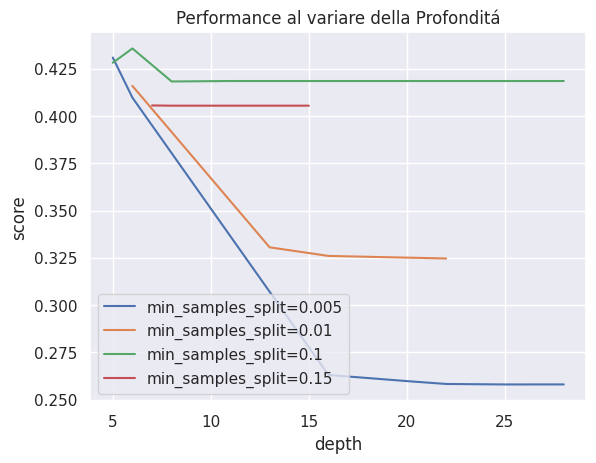

In [55]:
for split in splits:
    subset = results[results["param_tree__min_samples_split"] == split]
    subset = subset.sort_values("param_tree__max_depth")
    plt.plot(
        subset["param_tree__max_depth"],
        subset["mean_test_score"],
        label=f"min_samples_split={split}"
    )

plt.xlabel('depth')
plt.ylabel('score')
plt.title("Performance al variare della Profonditá")
plt.legend()
plt.show()

## Random forest

In [56]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [57]:
%time model.fit(X_train, y_train)
print()

CPU times: user 6.83 s, sys: 76.6 ms, total: 6.91 s
Wall time: 4.46 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [58]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

,0
numeric__pm_lag_1W,0.232303
numeric__pm_lag_1Y,0.160013
numeric__pm_lag_2Y,0.129557
numeric__pm_lag_1M,0.107299
numeric__co_lag_1W,0.049193
numeric__co_lag_1Y,0.045464
numeric__dayofyear,0.040514
numeric__co_lag_2Y,0.034638
numeric__weekofyear,0.031846
numeric__co_lag_1M,0.029105


### Grid Search per random forest
Nella grid search cerchiamo i valori ottimali di `max_samples`, il numero massimo di campioni usati nell'addestramento di ciascun albero, e di `n_estimators`, il numero di alberi decisionali della foresta.

In [59]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = RandomizedSearchCV(model, grid, n_iter=16, cv=tscv, n_jobs=N_JOBS)

In [60]:
%time gs.fit(X_train, y_train)
print()

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 21.9 s, sys: 13.5 s, total: 35.4 s
Wall time: 9min 10s



In [61]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

In [62]:
results = pd.DataFrame(gs.cv_results_)[["param_tree__n_estimators","param_tree__max_samples","mean_test_score"]]
results_0_5 = results[results["param_tree__max_samples"] == 0.5]
results_0_6 = results[results["param_tree__max_samples"] == 0.6]
results_0_8 = results[results["param_tree__max_samples"] == 0.8]
results_1 = results[results["param_tree__max_samples"] == 1.0]

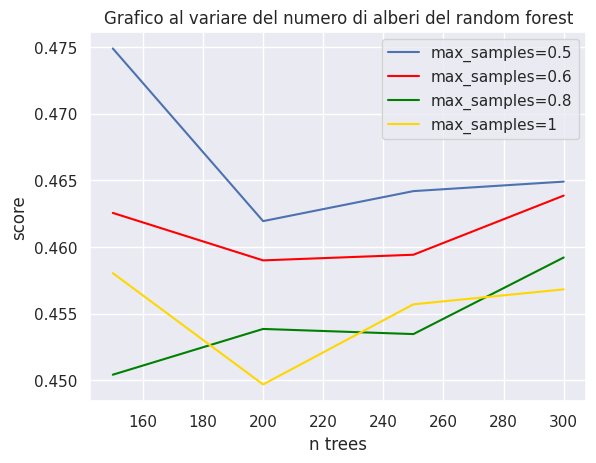

In [63]:
plt.plot(results_0_5["param_tree__n_estimators"], results_0_5["mean_test_score"])
plt.plot(results_0_6["param_tree__n_estimators"], results_0_6["mean_test_score"], c="red")
plt.plot(results_0_8["param_tree__n_estimators"], results_0_8["mean_test_score"], c="green")
plt.plot(results_1["param_tree__n_estimators"], results_1["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_samples=0.5","max_samples=0.6","max_samples=0.8","max_samples=1"])
plt.title('Grafico al variare del numero di alberi del random forest')
plt.show()

## XGBoost
XGBoost crea una foresta di alberi in cui ogni albero utilizza gli errori commessi dall'albero precedente.

In [64]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [65]:
%time model.fit(X_train, y_train)
print()

CPU times: user 2.19 s, sys: 195 ms, total: 2.38 s
Wall time: 1.62 s



Possiamo ricavare le 5 feature più importanti per XGBoost, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [66]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

,0
numeric__pm_lag_1W,0.418547
numeric__month,0.130303
numeric__pm_lag_1Y,0.111615
numeric__weekofyear,0.050576
numeric__pm_lag_2Y,0.048516


### Grid Search per XGBoost
Cerchiamo i valori ottimali di due iperparametri: la profondità massima degli alberi e il numero di alberi della foresta.

In [67]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

In [68]:
%time gs.fit(X_train, y_train)
print()

CPU times: user 2.75 s, sys: 363 ms, total: 3.11 s
Wall time: 4min 57s



In [69]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

In [70]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

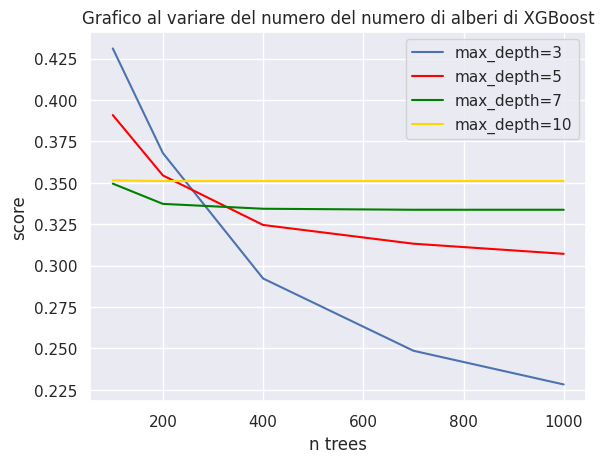

In [71]:
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## MLP

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

Device utilizzato: cuda


### Random Search con Early Stopping

Questo blocco di codice implementa una procedura completa di **Random Search** per la selezione di iperparametri di modelli di regressione in PyTorch, integrando una strategia di **Early Stopping** per migliorare l'efficienza del training.

* La classe `EarlyStopper` consente di interrompere l'addestramento anticipatamente se la loss di validazione non migliora per un numero di epoche definito (`patience`), riducendo il rischio di overfitting e velocizzando l'ottimizzazione.
* Le funzioni `train_epoch` ed `eval_loss` gestiscono rispettivamente il training e la valutazione della loss media su un dataset.
* La funzione principale `random_search` esegue una **Cross-Validation**, dove:
  * Il ciclo valuta le prestazioni generali del modello su diversi split train/test.

In [78]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4):
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Random Search con Time Series Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            sub_train = Subset(dataset, train_idx)
            val_set = Subset(dataset, val_idx)
            train_loader = DataLoader(sub_train, batch_size=train_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_set, batch_size=train_params['batch_size'], shuffle=False)

            model = model_builder(**model_params).to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(train_params['max_epochs']):
                train_epoch(model, train_loader, optimizer, nn.MSELoss())
                val_loss = eval_loss(model, val_loader, nn.MSELoss())

                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"    Epoch {epoch}: val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}")
                    break

            final_val_loss = eval_loss(model, val_loader, nn.MSELoss())
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Esecuzione del Random Search su MLP

In questa sezione viene eseguita la **ricerca di iperparametri tramite Random Search** per **MLP (Multi-Layer Perceptron)**.

#### Definizione degli spazi degli iperparametri:

* `mlp_param_dist`: contiene combinazioni di dimensioni dei layer nascosti, tassi di dropout, learning rate, batch size e numero massimo di epoche per il training del modello MLP.


In [79]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# (Training + Validation) Dataset
full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50]
}
best_model, model_params, train_params = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset
)

X_train_tensor = torch.stack([full_dataset[i][0] for i in range(len(full_dataset))])
y_train_tensor = torch.stack([full_dataset[i][1] for i in range(len(full_dataset))])
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

get_torch_estimator_scores("MLP", best_model,
                           X_train_tensor.to(device), y_train_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device)

Avvio Random Search con Time Series Cross Validation...
Testing parameter set 1/10
  Fold 1/5
    Epoch 0: val_loss = 2114.856022
    Epoch 10: val_loss = 1601.214123
    Epoch 20: val_loss = 1456.820547
    Epoch 30: val_loss = 1400.332707
    Epoch 40: val_loss = 1323.468695
    Early stopping at epoch 45
  Fold 2/5
    Epoch 0: val_loss = 2601.610091
    Epoch 10: val_loss = 1077.142362
    Epoch 20: val_loss = 867.462952
    Early stopping at epoch 29
  Fold 3/5
    Epoch 0: val_loss = 996.148921
    Epoch 10: val_loss = 344.961065
    Epoch 20: val_loss = 334.456390
    Epoch 30: val_loss = 319.720234
    Epoch 40: val_loss = 308.147153
  Fold 4/5
    Epoch 0: val_loss = 1617.910217
    Epoch 10: val_loss = 638.659396
    Epoch 20: val_loss = 574.843927
    Epoch 30: val_loss = 555.954905
    Early stopping at epoch 32
  Fold 5/5
    Epoch 0: val_loss = 667.291412
    Epoch 10: val_loss = 395.502041
    Epoch 20: val_loss = 376.428489
    Early stopping at epoch 27
  Mean validati

## Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **RMSE (Root Mean Squared Error)**: evidenzia la variabilità degli errori di previsione, penalizzando fortemente gli outlier.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **MSLE (Mean Squared Logarithmic Error)**: utile nei casi in cui gli errori relativi siano più importanti degli assoluti, o in presenza di target con ordini di grandezza diversi.
- **Explained Variance Score**: indica la proporzione della varianza spiegata dal modello (simile a $R^2$).
- **Max Error**: evidenzia il peggior errore assoluto commesso su un'osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche `RMSE`, `MAE` e `MAPE` viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata alla metrica.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.


In [80]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']]
    melted_r2 = melted_r2.rename(columns={'r2_train':'train','r2_test':'test'})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')

    fig, axs = plt.subplots(3, 3, figsize=(18, 14))
    fig.tight_layout(pad=4)

    sns.barplot(data=melted_r2, x='score', y='model', hue='set', ax=axs[0,0])
    axs[0,0].set_title('R2 Score')
    axs[0,0].legend(loc='lower right')

    axs[0,1].set_title('RMSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,1].barh(row['model'], row['rmse'],
                      xerr=[[row['rmse']-row['rmse_low']], [row['rmse_high']-row['rmse']]], capsize=5)

    axs[0,2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0,2].barh(row['model'], row['mae'],
                      xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]], capsize=5)

    axs[1,0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1,0].barh(row['model'], row['mape'],
                      xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]], capsize=5)

    axs[1,1].set_title('MSLE')
    for _, row in scores.iterrows():
        axs[1,1].barh(row['model'], row['msle'])

    axs[1,2].set_title('Explained Variance')
    for _, row in scores.iterrows():
        axs[1,2].barh(row['model'], row['explained_var'])
    axs[1,2].set_xlim(0,1)

    axs[2,0].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[2,0].barh(row['model'], row['max_error'])

    axs[2,1].axis('off')
    axs[2,2].axis('off')

    plt.show()

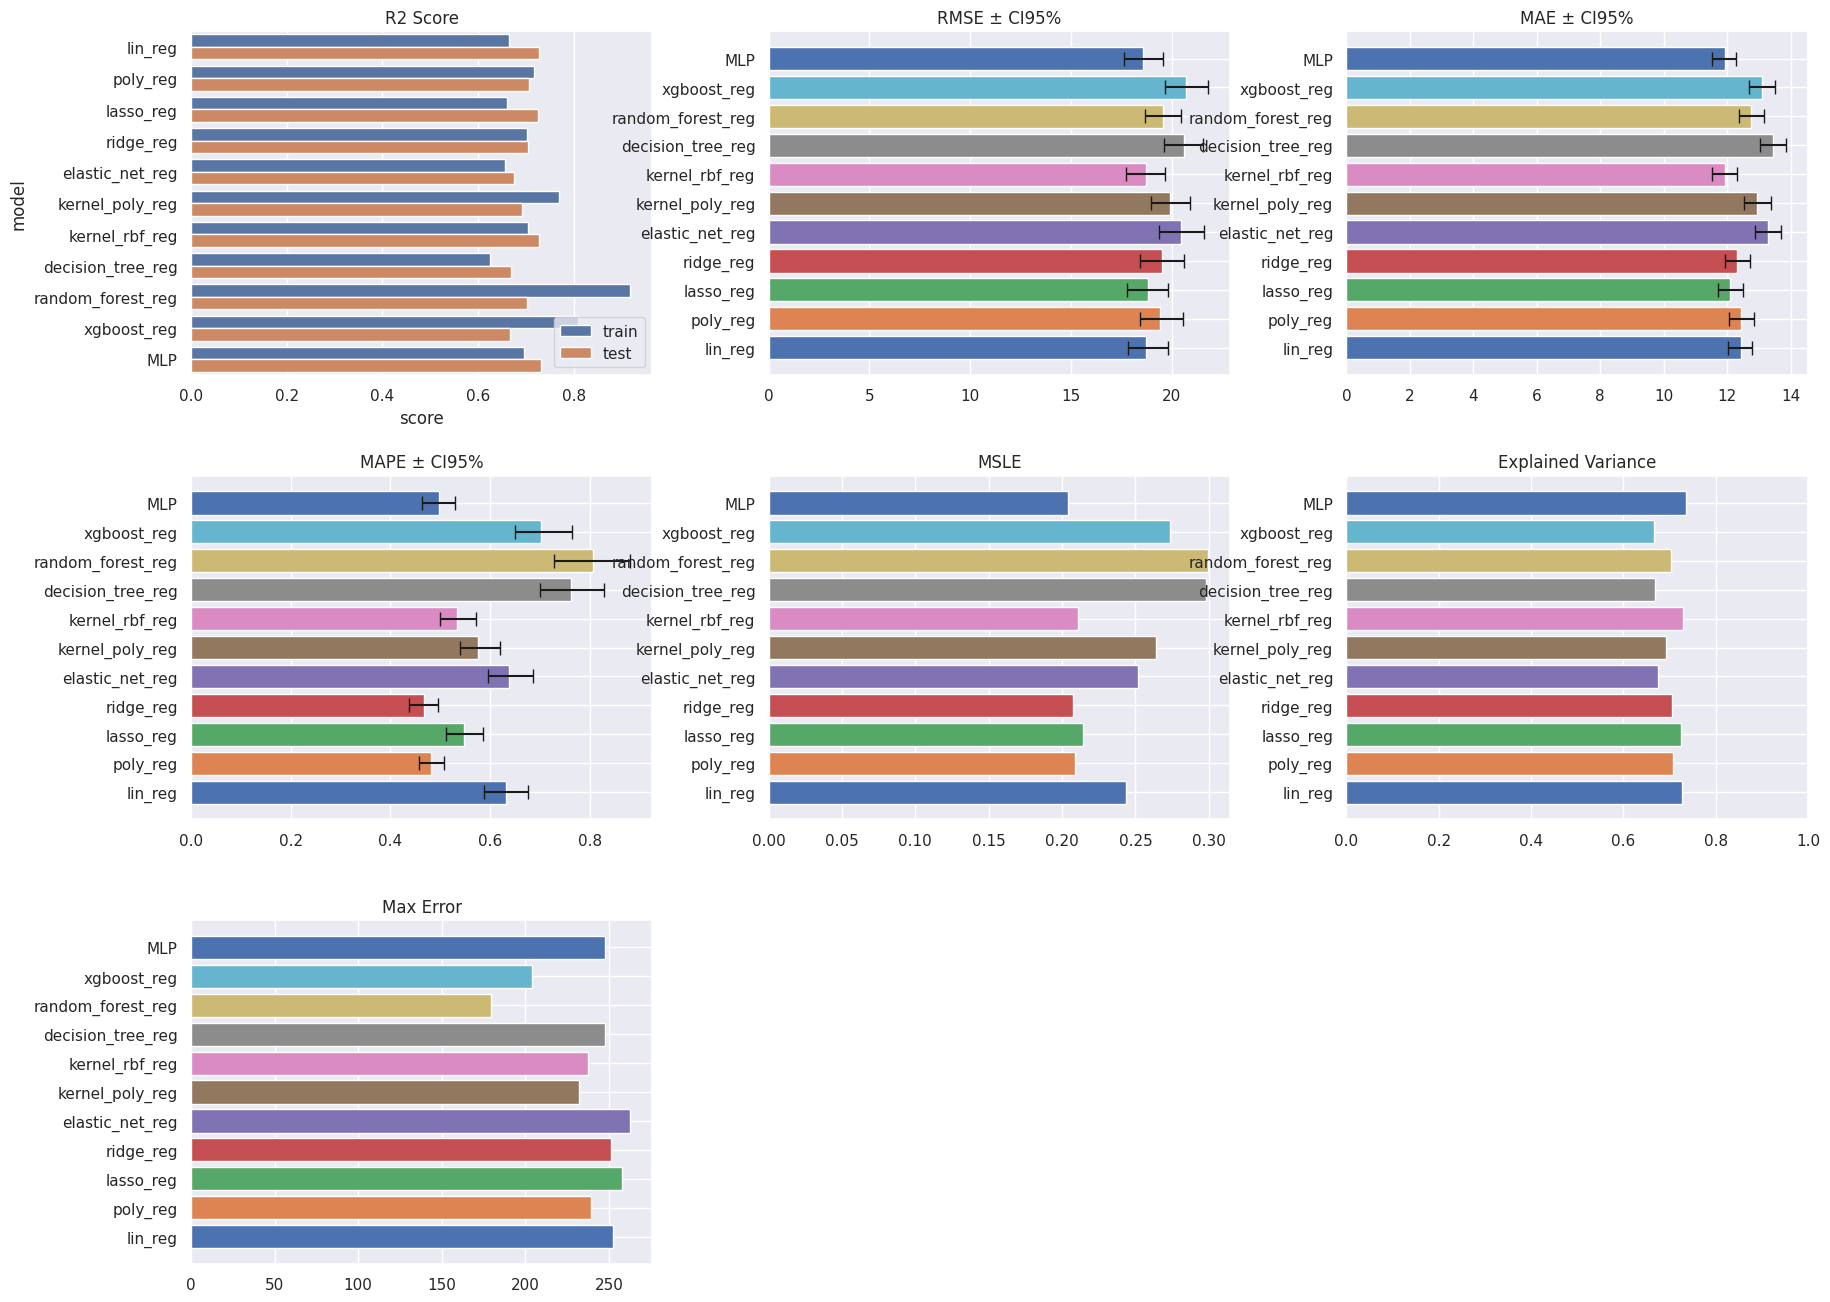

In [81]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model','r2_train','r2_test',
        'rmse','rmse_low','rmse_high',
        'mae','mae_low','mae_high',
        'mape','mape_low','mape_high',
        'msle','explained_var','max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)